# Deep Learning Time Series COVID-19 Cases Prediction

### **Import libraries** and **packages**

In [330]:
import numpy as np
import pandas as pd
import scipy
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.express as px
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import requests
import pandas_profiling
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers.experimental.preprocessing import Normalization
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM, GRU, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import RMSprop 
from covid_time_series_prediction.data.data.country_data import country_output

## Data Sourcing

### Data API 

#### By country over time

In [239]:
def fetch_time_series(feature='stringency', start_date='2020-02-14', end_date='2021-02-14'):
    """
    Get stringency time series for each countries requesting API.
    Returns json dict with TS between start_date and end_date like 'YYYY-MM-DD'.
    """
    url = f'https://covidtrackerapi.bsg.ox.ac.uk/api/v2/{feature}/date-range/{start_date}/{end_date}'
    response = requests.get(url)
    if response.status_code != 200:
        return ''
    data = response.json()
    return data

In [240]:
countries_time_series_api = fetch_time_series()

In [241]:
[(k, [c for c in v if c == 'VNM'])  for k, v in countries_time_series_api.items()  if k == 'countries' ]

[('countries', ['VNM'])]

In [242]:
[([([([(vee)  for kaaa, veee  in vee.items() if kaaa in ['date_value', 'confirmed']  ])  for kaa, vee  in ve.items() if kaa =='VNM'   ])  for ka, ve  in v.items() ])  for k, v in countries_time_series_api.items() if k=='data'   ]

[[[[{'date_value': '2020-02-14',
     'country_code': 'VNM',
     'confirmed': 16,
     'deaths': 0,
     'stringency_actual': 45.37,
     'stringency': 45.37,
     'stringency_legacy': 54.76,
     'stringency_legacy_disp': 54.76},
    {'date_value': '2020-02-14',
     'country_code': 'VNM',
     'confirmed': 16,
     'deaths': 0,
     'stringency_actual': 45.37,
     'stringency': 45.37,
     'stringency_legacy': 54.76,
     'stringency_legacy_disp': 54.76}]],
  [[{'date_value': '2020-02-15',
     'country_code': 'VNM',
     'confirmed': 16,
     'deaths': 0,
     'stringency_actual': 47.22,
     'stringency': 47.22,
     'stringency_legacy': 58.33,
     'stringency_legacy_disp': 58.33},
    {'date_value': '2020-02-15',
     'country_code': 'VNM',
     'confirmed': 16,
     'deaths': 0,
     'stringency_actual': 47.22,
     'stringency': 47.22,
     'stringency_legacy': 58.33,
     'stringency_legacy_disp': 58.33}]],
  [[{'date_value': '2020-02-16',
     'country_code': 'VNM',
     'c

In [243]:
[(k, [(ka, [(kaa, vee)  for kaa, vee  in ve.items() if kaa =='USA'   ])  for ka, ve  in v.items() ])  for k, v in countries_time_series_api.items() if k=='data'   ]

[('data',
  [('2020-02-14',
    [('USA',
      {'date_value': '2020-02-14',
       'country_code': 'USA',
       'confirmed': 14,
       'deaths': 0,
       'stringency_actual': 5.56,
       'stringency': 5.56,
       'stringency_legacy': 7.14,
       'stringency_legacy_disp': 7.14})]),
   ('2020-02-15',
    [('USA',
      {'date_value': '2020-02-15',
       'country_code': 'USA',
       'confirmed': 14,
       'deaths': 0,
       'stringency_actual': 5.56,
       'stringency': 5.56,
       'stringency_legacy': 7.14,
       'stringency_legacy_disp': 7.14})]),
   ('2020-02-16',
    [('USA',
      {'date_value': '2020-02-16',
       'country_code': 'USA',
       'confirmed': 14,
       'deaths': 0,
       'stringency_actual': 5.56,
       'stringency': 5.56,
       'stringency_legacy': 7.14,
       'stringency_legacy_disp': 7.14})]),
   ('2020-02-17',
    [('USA',
      {'date_value': '2020-02-17',
       'country_code': 'USA',
       'confirmed': 14,
       'deaths': 0,
       'stringen

#### Country data for a specific day

In [244]:
def fetch_data(country='USA', date='2020-08-14'):
    """
    Get stringency data for one country {ALPHA-3} requesting API.
    Returns json dict with data for country like 'AAA' and specific date and like 'YYYY-MM-DD'.
    """
    url = f'https://covidtrackerapi.bsg.ox.ac.uk/api/v2/stringency/actions/{country}/{date}'
    response = requests.get(url)
    if response.status_code != 200:
        return ''
    data = response.json()
    return data

In [245]:
country_data_api = fetch_data()

In [246]:
[[';'.join([str(kk) for kk, vv in d.items()]) for i, d in enumerate(v) if type(d) == dict and i == 0] for v in country_data_api.values()][0]

['policy_type_code;policy_type_display;policyvalue;policyvalue_actual;flagged;is_general;notes;flag_value_display_field;policy_value_display_field']

In [247]:
[[';'.join([str(vv) for kk, vv in d.items()]) for d in v if type(d) == dict] for v in country_data_api.values()][0]

['C1;School closing;3;3;False;False;According to the New York Times, New York City is the only major school district in the country to open for students part-time this fall. \r\n\r\nSee the article in the New York Times, archived: http://archive.vn/OkUNQ;General;Require closing (all levels)',
 'C2;Workplace closing;2;2;False;False;None;General;Require closing some sectors',
 'C3;Cancel public events;2;2;False;False;None;General;Required',
 'C4;Restrictions on gatherings;4;4;False;False;None;General;Restrictions on gatherings of 10 or fewer people',
 'C5;Close public transport;1;1;False;False;None;General;Recommended',
 'C6;Stay at home requirements;1;1;True;True;None;General;Recommend staying home',
 'C7;Restrictions on internal movement;2;2;False;False;None;General;Required',
 'C8;International travel controls;3;3;None;None;None;Ban',
 'E1;Income support;2;2;False;False;None;All workers;>50% lost income',
 'E2;Debt/contract relief;1;1;None;None;None;Narrow',
 'E3;Fiscal measures;0;0;N

In [248]:
# [';'.join([str(vv) for vv in v]) for v in country_data_api.values()][-1]
[';'.join([str(kk) for kk in v]) for k, v in country_data_api.items()][-1]

'date_value;country_code;confirmed;deaths;stringency_actual;stringency'

### CSV data

#### **Read URL**, **Get CSV files** and **store CSV in local**  *(optional do it at begining or to refresh CSV data)*

##### **get_database_to_csv()** function

In [249]:
def get_database_to_csv(url, csv_list, path='', db_grid=[]) -> list:
    """
    function that take in parameter:
     - a root URL (string) to get the CSV data,
     - a list of CSV files,
     - a path (string) to store CSV in local,
     - a grid (list of list) to add in the CSV filename, URL, local path.     
    and returns the gird updated with the CSVs of the list
    
    """

    ### Create a database grid (list of list) with all CSVs and associated URLs
    # print('db_grid', db_grid)
    #### Data project directory (if empty do not store CSV in local)
    # print('path', path)
    ### Website CSV datasets URL
    # print('url', url)
    #### List of CSVs of Website to retrieve
    # print('csv_list', csv_list)

    #### Length of grid aka number of CSVs already stored in grid
    len_grid = len(db_grid)

    for l in range(len(csv_list)):
        # g = l + len_grid
        sub_list = []       
        sub_list.append(csv_list[l]) ## 1st pos°: CSV filename
        sub_list.append(url + csv_list[l]) ## 2nd pos°: URL + CSV
        if len(data_dir) > 0: ## store CSV in local
            sub_list.append(data_dir + csv_list[l]) ## 3rd pos°: local data path + CSV
            !curl -L "{url + csv_list[l]}" > {data_dir + csv_list[l]} ## curl <URL>/<CSV> => <path>
        print('sub_list', sub_list)
        db_grid.append(sub_list)

    ### Return a database grid (list of list) with all CSVs and associated URLs
    return db_grid

#### **Get database to csv**

In [250]:
#### Data project directory
data_dir = '../raw_data/'

### Oxford Master data time series URL
url_root_oxford = 'https://raw.githubusercontent.com/OxCGRT/covid-policy-tracker/master/data/timeseries/'

#### List of CSVs of Oxford database Feel free to add more feature...
csv_list = ['confirmed_cases.csv', 'confirmed_deaths.csv', 'government_response_index_avg.csv', 'stringency_index_avg.csv', 
            'containment_health_index_avg.csv', 'economic_support_index.csv', 'c1m_school_closing.csv', 
            'c2m_workplace_closing.csv', 'c3m_cancel_public_events.csv', 'c4m_restrictions_on_gatherings.csv', 
            'c5m_close_public_transport.csv', 'c6m_stay_at_home_requirements.csv', 'c7m_movementrestrictions.csv',
            'c8ev_internationaltravel.csv', 'e1_income_support.csv', 'e2_debtrelief.csv', 'h1_public_information_campaigns.csv',
            'h2_testing_policy.csv', 'h3_contact_tracing.csv', 'h6m_facial_coverings.csv',
            'h7_vaccination_policy.csv', 'h8m_protection_of_elderly_ppl.csv'
           ]
# print(csv_list)
    
### Vacinations Dataset URLs
url_root_vaccinations = 'https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/vaccinations/'

#### List of CSVs of Vaccinations database
csv_list_vax = ['vaccinations.csv', 'vaccinations-by-age-group.csv']
# print(csv_list_vax)

### Create a database grid (list of list) with all CSVs and associated URLs
# db_grid = [[]]
# print(db_grid)
### Insert into database grid all CSVs and associated URLs from Oxford website
db_grid = get_database_to_csv(url_root_oxford, csv_list, data_dir) ## uncomment to store CSV
### Insert into database grid all CSVs and associated URLs from vaccinations website
db_grid = get_database_to_csv(url_root_vaccinations, csv_list_vax, data_dir, db_grid)
# print('db_grid', db_grid)

# Stack all csl in the list
csv_list += csv_list_vax

# transform list into dict:
csv = dict(zip(csv_list, [v[0] for v in enumerate(csv_list)])) # if v[1] == 'containment_health_index_avg.csv'
csv

zsh:1: no such file or directory: ../raw_data/confirmed_cases.csv
sub_list ['confirmed_cases.csv', 'https://raw.githubusercontent.com/OxCGRT/covid-policy-tracker/master/data/timeseries/confirmed_cases.csv', '../raw_data/confirmed_cases.csv']
zsh:1: no such file or directory: ../raw_data/confirmed_deaths.csv
sub_list ['confirmed_deaths.csv', 'https://raw.githubusercontent.com/OxCGRT/covid-policy-tracker/master/data/timeseries/confirmed_deaths.csv', '../raw_data/confirmed_deaths.csv']
zsh:1: no such file or directory: ../raw_data/government_response_index_avg.csv
sub_list ['government_response_index_avg.csv', 'https://raw.githubusercontent.com/OxCGRT/covid-policy-tracker/master/data/timeseries/government_response_index_avg.csv', '../raw_data/government_response_index_avg.csv']
zsh:1: no such file or directory: ../raw_data/stringency_index_avg.csv
sub_list ['stringency_index_avg.csv', 'https://raw.githubusercontent.com/OxCGRT/covid-policy-tracker/master/data/timeseries/stringency_index_av

{'confirmed_cases.csv': 0,
 'confirmed_deaths.csv': 1,
 'government_response_index_avg.csv': 2,
 'stringency_index_avg.csv': 3,
 'containment_health_index_avg.csv': 4,
 'economic_support_index.csv': 5,
 'c1m_school_closing.csv': 6,
 'c2m_workplace_closing.csv': 7,
 'c3m_cancel_public_events.csv': 8,
 'c4m_restrictions_on_gatherings.csv': 9,
 'c5m_close_public_transport.csv': 10,
 'c6m_stay_at_home_requirements.csv': 11,
 'c7m_movementrestrictions.csv': 12,
 'c8ev_internationaltravel.csv': 13,
 'e1_income_support.csv': 14,
 'e2_debtrelief.csv': 15,
 'h1_public_information_campaigns.csv': 16,
 'h2_testing_policy.csv': 17,
 'h3_contact_tracing.csv': 18,
 'h6m_facial_coverings.csv': 19,
 'h7_vaccination_policy.csv': 20,
 'h8m_protection_of_elderly_ppl.csv': 21,
 'vaccinations.csv': 22,
 'vaccinations-by-age-group.csv': 23}

### *Get database to csv one by one*


#### Target URLs
url_cases = url_root_oxford + 'confirmed_cases.csv'
url_deaths = url_root_oxford + 'confirmed_deaths.csv'

#### Index URLs
url_id1= url_root_oxford + csv_i1 ## index_strigency
url_id2 = url_root_oxford + csv_i2 ## index_gov_resp
url_id3_health = url_root_oxford + csv_i3 ## index_health
url_id4 = url_root_oxford + csv_i4 ## index_economic

#### C[1-8] URLs
url_c1 = url_root_oxford + csv_c1 ## 'C1;School closing;'
url_c2 = url_root_oxford + csv_c1 ## 'C2;Workplace closing;'
url_c3 = url_root_oxford + csv_c3 ## 'C3;Cancel public events;'
url_c4 = url_root_oxford + csv_c4 ## 'C4;Restrictions on gatherings;'
url_c5 = url_root_oxford + csv_c5 ## 'C5;Close public transport'
url_c6 = url_root_oxford + csv_c6 ## 'C6;Stay at home requirements;'
url_c7 = url_root_oxford + csv_c7 ## 'C7;Restrictions on internal movement;'
url_c8 = url_root_oxford + csv_c8 ##  'C8;International travel controls;'
 
#### E[1-4] URLs
url_e1 = url_root_oxford + csv_e1 ## 'E1;Income support;'
url_e2 = url_root_oxford + csv_e2 ## 'E2;Debt/contract relief;'
url_e3 = url_root_oxford + csv_e3 ## 'E3;Fiscal measures;'
url_e4 = url_root_oxford + csv_e4 ## 'E4;International support;'
 
#### H[1-8] URLs
url_h1 = url_root_oxford + csv_h1 ## 'H1;Public information campaigns;'
url_h2 = url_root_oxford + csv_h2 ## 'H2;Testing policy'
url_h3 = url_root_oxford + csv_h3 ## 'H3;Contact tracing;'
url_h3 = url_root_oxford + csv_h4 ## 'H4;Emergency investment in healthcare;0;0;None;None;None;USD Value',
url_h3 = url_root_oxford + csv_h5 ## 'H5;Investment in vaccines;0;0;None;None;None;USD Value',
url_h3 = url_root_oxford + csv_h6 ## 'H6;Facial Coverings;0;0;None;None;None;General;No policy',
url_h3 = url_root_oxford + csv_h7 ## 'H7;Vaccination policy;0;0;None;None;None;Government funded;No availability',
url_h3 = url_root_oxford + csv_h8 ## 'H8;Protection of elderly people;1;1;True;True;None;General;Recommended protections',

#### V[1-4] URLs
url_v1 = url_root_oxford + csv_h1 ## 'V1;Vaccine Prioritisation;-2;-2;None;None;None',
url_v2 = url_root_oxford + csv_h2 ## 'V2;Vaccine Availability;-2;-2;None;None;None',
url_v3 = url_root_oxford + csv_h3 ## 'V3;Vaccine Financial Support;-2;-2;None;None;None',
url_v4 = url_root_oxford + csv_h4 ## 'V4;Mandatory Vaccination;-2;-2;None;None;None']

### Vacinations Dataset URLs
url_root_vaccinations = 'https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/vaccinations/'
url_v5  = url_root_vaccinations + csv_v5 ## '/vaccinations.csv'
url_v6 = url_root_vaccinations + csv_v6 ## 'vaccinations-by-age-group.csv'


#### DataFrame Index
!curl -L "{url_i1}" > {data_dir}{csv_i1}
!curl -L "{url_i2}" > {data_dir}{csv_i2}
!curl -L "{url_i3}" > {data_dir}{csv_i3}
!curl -L "{url_i4}" > {data_dir}{csv_i4}
!curl -L "{url_c1}" > {data_dir}{csv_c1}
!curl -L "{url_c2}" > {data_dir}{csv_c2}
!curl -L "{url_c3}" > {data_dir}{csv_c3}
!curl -L "{url_c4}" > {data_dir}{csv_c4}
!curl -L "{url_c5}" > {data_dir}{csv_c5}
!curl -L "{url_c6}" > {data_dir}{csv_c6}
!curl -L "{url_c7}" > {data_dir}{csv_c7}
!curl -L "{url_c8}" > {data_dir}{csv_c8}

df_raw_school_closing=pd.read_csv('../raw_data/c1m_school_closing.csv')
df_raw_workplace_closing=pd.read_csv('../raw_data/c2m_workplace_closing.csv')
df_raw_cancel_public_event=pd.read_csv('../raw_data/c3m_cancel_public_events.csv')
df_raw_restriction_on_gathering=pd.read_csv('../raw_data/c4m_restrictions_on_gatherings.csv')
df_raw_stay_at_home=pd.read_csv('../raw_data/c6m_stay_at_home_requirements.csv')
df_raw_international_travel=pd.read_csv('../raw_data/c6m_stay_at_home_requirements.csv')
df_raw_goverment_response=pd.read_csv('../raw_data/government_response_index_avg.csv')
df_raw_facial_covering=pd.read_csv('../raw_data/h6m_facial_coverings.csv')
df_raw_vacination_policy=pd.read_csv('../raw_data/h7_vaccination_policy.csv')



#### Vaccination
!curl -L "{url_vaccination}" > {data_dir}{vaccination_csv}
!curl -L "{url_ages}" > {data_dir}{ages_csv}

#### CSV target
!curl -L "{url_cases}" > {data_dir}{cases_csv}
!curl -L "{url_deaths}" > {data_dir}{deaths_csv}



### **Read CSV** and **Set raw dataframe**

In [251]:
db_grid[csv['containment_health_index_avg.csv']]

['containment_health_index_avg.csv',
 'https://raw.githubusercontent.com/OxCGRT/covid-policy-tracker/master/data/timeseries/containment_health_index_avg.csv',
 '../raw_data/containment_health_index_avg.csv']

In [252]:
#### Data project directory
data_dir = '..data/raw_data/'

#### CSV Data out project directory
csv_dir = '../data/csv_out/'

# df_raw_gov_response = pd.read_csv(data_dir + 'government_response_index_avg.csv')
# df_raw_health = pd.read_csv(data_dir + 'containment_health_index_avg.csv')
# df_raw_economic = pd.read_csv(data_dir + 'economic_support_index.csv')

#### Vaccination
# df_raw_vaccination = pd.read_csv(data_dir + 'vaccinations.csv')
# df_raw_ages = pd.read_csv(data_dir + 'vaccinations-by-age-group.csv')


#### Data Frame target
# df_raw_cases = pd.read_csv(data_dir + 'confirmed_deaths.csv')
# df_raw_deaths = pd.read_csv(data_dir + 'confirmed_deaths.csv')

#### Data multiple
# df_raw_confirmed_cases=pd.read_csv(url_cases)
# df_raw_death=pd.read_csv(data_dir + 'confirmed_deaths.csv')
# df_raw_school_closing=pd.read_csv(data_dir + 'c1m_school_closing.csv')
# df_raw_workplace_closing=pd.read_csv(data_dir + 'c2m_workplace_closing.csv')
# df_raw_cancel_public_event=pd.read_csv(data_dir + 'c3m_cancel_public_events.csv')
# df_raw_restriction_on_gathering=pd.read_csv(data_dir + 'c4m_restrictions_on_gatherings.csv')
# df_raw_stay_at_home=pd.read_csv(data_dir + 'c6m_stay_at_home_requirements.csv')
# df_raw_international_travel=pd.read_csv(data_dir + 'c6m_stay_at_home_requirements.csv')
# df_raw_goverment_response=pd.read_csv(data_dir + 'government_response_index_avg.csv')
# df_raw_facial_covering=pd.read_csv(data_dir + 'h6m_facial_coverings.csv')
# df_raw_vacination_policy=pd.read_csv(data_dir + 'h7_vaccination_policy.csv')


df_usa_index =  pd.read_csv(csv_dir + 'usa_index.csv')
df_usa_indicator =  pd.read_csv(csv_dir + 'usa_indicator.csv')
df_usa_index, df_usa_indicator

(           date  containment_and_health  stringency  economics_sup  \
 0    2020-01-01                     0.0         0.0            0.0   
 1    2020-01-02                     0.0         0.0            0.0   
 2    2020-01-03                     0.0         0.0            0.0   
 3    2020-01-04                     0.0         0.0            0.0   
 4    2020-01-05                     0.0         0.0            0.0   
 ..          ...                     ...         ...            ...   
 977  2022-09-04                     0.0         0.0            0.0   
 978  2022-09-05                     0.0         0.0            0.0   
 979  2022-09-06                     0.0         0.0            0.0   
 980  2022-09-07                     0.0         0.0            0.0   
 981  2022-09-08                     0.0         0.0            0.0   
 
      total_cases   new_cases  total_deaths  new_deaths  gov_response  \
 0            0.0         NaN           0.0         NaN          0.00   


In [253]:
# df_ts_usa_index =  df_usa_index.copy()
df_ts_usa_indicator =  df_usa_indicator.copy()

## Exploratory Data Analyzis

### Time Series Analysis

In [254]:
ts_cases = df_raw_cases.drop(columns=['country_name','region_code','region_name','jurisdiction','Unnamed: 0'])
ts_cases = ts_cases.groupby('country_code').agg('sum')
ts_cases.transpose()
ts_cases.columns.name = 'Dates'
ts_cases = ts_cases.fillna(0)
# ts_cases.index = pd.to_datetime(ts_cases.index)

vn_ts_cases = vn_data.drop(columns=['country_name','region_code','region_name','jurisdiction','Unnamed: 0'])
vn_ts_cases = vn_ts_cases.groupby('country_code').agg('sum')
vn_ts_cases.transpose()
vn_ts_cases.columns.name = 'Dates'
vn_ts_cases = vn_ts_cases.fillna(0)
#### ts_cases.index = pd.to_datetime(ts_cases.index)

df_raw_cases.head()

In [255]:
ts_cases = ts_cases.transpose()
ts_cases.head()

country_code,ABW,AFG,AGO,ALB,AND,ARE,ARG,AUS,AUT,AZE,...,USA,UZB,VEN,VIR,VNM,VUT,YEM,ZAF,ZMB,ZWE
Dates,,,,,,,,,,,,,,,,,,,,,
01Jan2020,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
02Jan2020,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
03Jan2020,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
04Jan2020,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
05Jan2020,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [256]:
ts_cases.shape

(982, 187)

In [257]:
vn_ts_cases

Dates,01Jan2020,02Jan2020,03Jan2020,04Jan2020,05Jan2020,06Jan2020,07Jan2020,08Jan2020,09Jan2020,10Jan2020,...,30Aug2022,31Aug2022,01Sep2022,02Sep2022,03Sep2022,04Sep2022,05Sep2022,06Sep2022,07Sep2022,08Sep2022
country_code,,,,,,,,,,,,,,,,,,,,,
VNM,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,43117.0,43117.0,43117.0,43118.0,43119.0,43120.0,43122.0,43123.0,0.0,0.0


In [258]:
vn_ts_cases = vn_ts_cases.transpose()

In [259]:
df_raw_cases.isna()

,Unnamed: 0,country_code,country_name,region_code,region_name,jurisdiction,01Jan2020,02Jan2020,03Jan2020,04Jan2020,...,30Aug2022,31Aug2022,01Sep2022,02Sep2022,03Sep2022,04Sep2022,05Sep2022,06Sep2022,07Sep2022,08Sep2022
0,False,False,False,True,True,False,True,True,True,True,...,False,False,False,False,False,False,False,False,True,True
1,False,False,False,True,True,False,True,True,True,True,...,False,False,False,False,False,False,False,False,True,True
2,False,False,False,True,True,False,True,True,True,True,...,False,False,False,False,False,False,False,False,True,True
3,False,False,False,True,True,False,True,True,True,True,...,False,False,False,False,False,False,False,False,True,True
4,False,False,False,True,True,False,True,True,True,True,...,False,False,False,False,False,False,False,False,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
258,False,False,False,True,True,False,True,True,True,True,...,False,False,False,False,False,False,False,False,True,True
259,False,False,False,True,True,False,True,True,True,True,...,False,False,False,False,False,False,False,False,True,True
260,False,False,False,True,True,False,True,True,True,True,...,False,False,False,False,False,False,False,False,True,True
261,False,False,False,True,True,False,True,True,True,True,...,False,False,False,False,False,False,False,False,True,True


In [260]:
# get VietNam country dataset
vn_data = df_raw_cases.loc[df_raw_cases['country_code'] == 'VNM'].copy()

vn_data.head()

,Unnamed: 0,country_code,country_name,region_code,region_name,jurisdiction,01Jan2020,02Jan2020,03Jan2020,04Jan2020,...,30Aug2022,31Aug2022,01Sep2022,02Sep2022,03Sep2022,04Sep2022,05Sep2022,06Sep2022,07Sep2022,08Sep2022
257,258,VNM,Vietnam,NaN,NaN,NAT_TOTAL,NaN,NaN,NaN,NaN,...,43117.0,43117.0,43117.0,43118.0,43119.0,43120.0,43122.0,43123.0,NaN,NaN


In [261]:
# %%time
# vn_data.profile_report()

## Time Series Analysis & last cleaning

In [262]:
df_ts_usa_index = df_usa_index.copy()
df_ts_usa_index.drop(columns=['date', 'new_deaths', 'new_cases'],inplace=True)
y_seq = 'total_deaths'
df_ts_usa_index = df_ts_usa_index.fillna(0)
print(df_ts_usa_index.shape[1])
df_ts_usa_index

9


,containment_and_health,stringency,economics_sup,total_cases,total_deaths,gov_response,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,total_boosters_per_hundred
0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0
1,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0
2,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0
3,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0
4,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0
...,...,...,...,...,...,...,...,...,...
977,0.0,0.0,0.0,188464761.0,2089425.0,2146.68,79.24,67.58,39.5
978,0.0,0.0,0.0,188503831.0,2089567.0,2146.68,79.25,67.58,39.5
979,0.0,0.0,0.0,188761844.0,2090809.0,2146.68,79.25,67.58,39.5
980,0.0,0.0,0.0,103838653.0,0.0,2146.68,0.00,0.00,0.0


# RNN MODEL

# Auto reload imported module every time a jupyter cell is executed (handy for olist.order.py updates)
%load_ext autoreload
%autoreload 2
from covid_time_series_prediction.indicator import Indicator
from indicator.data import Olist
Indicator().ping()
indicator = Indicator()
data = indicator.get_data()
data

country_index, country_indicator = Indicator().get_country_data(country_name='France')
country_index, country_indicator

## Recurrent Neural Network (sequences data) modeling

### Samples/Sequences, Observations, Features

X.shape = (n_SEQUENCES, n_OBSERVATIONS, n_FEATURES)

y = RNN(X)

❗️ Notation $X_{i,j}^{t}$

 $_{i}$ is the sample/sequence
 
 $_{j}$ is the feature measured
 
 $^{t}$ is the time at which the observation is seen

In [263]:
n_seq = 50 # ts_cases.shape[0] - 1 # nb of countries (samples)
n_obs = 15 # 15 days of training periiod (observations)
n_feat = df_ts_usa_index.shape[1] # 1 # 1feature: covid cases
n_pred = 1 # nb of days of prediction
n_feat

9

In [ ]:
# 3. Training
from typing import overload


def train_rnn_model(model, patience=20, epochs=200):
    es = EarlyStopping(monitor = 'val_loss',
                    patience = patience,
                    verbose = 0,
                    restore_best_weights = True)
    # The fit
    history =  model.fit(X_train,
            y_train, 
            validation_split=0.1, # Auto split for validation data
                ## validation_data = (X_val, y_val), # To be created manually if needed
            batch_size = 16,
            epochs = epochs,
            callbacks = [es],
            verbose=1)
    return history


print(type(overfit_es), overfit_es)
# if overfit_es:
#     print("early stopping")
#     history = train_rnn_model(patience=overfit_es)
# else:
# print("No early stopping")
# history = train_rnn_model()

<class 'list'> [50, 66, 26, 45, 60]


In [313]:
n_seq = 400 # ts_cases.shape[0] - 1 # nb of countries (samples)
n_obs = 150 # 15 days of training periiod (observations)
n_feat = df_ts_usa_index.shape[1] # 1 # 1feature: covid cases
n_pred = 1 # nb of days of prediction
n_feat

9

X = np.array(ts).astype(np.float32)

y = np.array([y_a, y_b, y_c]).astype(np.float32)



### Prerequisites:

- **retrieve dataset** from Alberto

    - **clean dataset**: 
        
        - **drop first lines == 0** *(before Covid arrived)*
        
        - **check Nan**: 
- **strategy 1 country by country** sequences split as follow:

- **strategy 2 one sequence per country**:
    - **split X train, set** 
    - **Pad sequences**
    - **create one csv per country**

#### Create sequences (`X`,`y`)

def **subsample_sequence(df, length)** -> pd.DataFrame:

function that given a full dataframe `df`:
- Create a sub sequences df, with long length?

In [264]:
def subsample_sequence(df, length) -> pd.DataFrame:
    """
    Given the initial dataframe `df`, return a shorter dataframe sequence of length `length` (eg n_obs).
    This shorter sequence should be selected at random
    """
    last_possible = df.shape[0] - length
    # How to split sequences? we could do it manually...
    random_start = np.random.randint(0, last_possible)
    df_sample = df[random_start: random_start+length]
    
    return df_sample

In [265]:
# Test it 
# assert subsample_sequence(vn_ts_cases, 10).shape  == (10, 1)
# assert subsample_sequence(vn_ts_cases, 400).shape == (400, 1)
subsample_sequence(df_ts_usa_index, 10).shape, subsample_sequence(df_ts_usa_index, 400).shape

((10, 9), (400, 9))

#### Pad `X` missing values with mean values

def **split_subsample_sequence(df,  length, sequence='VNM', df_mean=None)** -> tuple:

function that given a full dataframe `df`:
- Create a sub sequences df
- Stores the value of the covid deaths* (or cases) of the last day as your variable array `y`
- Stores all features of previous days as a variable `X`
- Returns (`X`, `y`)

* *'VNM_covd_deaths'* preference for death prediction, then switch on cases *'VNM_covid_cases'*

In [314]:
# length of a sequence
len_seq = n_obs + n_pred
# Ex: 16 = 15 + 1
len_seq

151

In [267]:
def split_subsample_sequence(df,  length, sequence='VNM', y_size=1) -> tuple:
    '''
    Create one single random (X_sample, y_sample)
    containing one sequence each of length `length`
    ToDo: Adapt the y size=-1'''
    # Trick to save time during potential recursive calls
    # if df_mean is None:
    #     df_mean = df.mean()
    df_subsample = subsample_sequence(df, length)
    y_sample = df_subsample.iloc[length - y_size][sequence] # ['VNM'] ['VNM_covid_cases', 'VNM_covd_deaths'] 
    # Case y_sample is NaN: redraw !
    # if y_sample != y_sample: # A value is not equal to itself only for NaN
    #         X_sample, y_sample = split_subsample_sequence(df, length, df_mean) # Recursive call !!!
    #         return np.array(X_sample), np.array(y_sample)    
    X_sample = df_subsample[0:length - y_size]
    # Case X_sample has some NaNs
    # if X_sample.isna().sum().sum() !=0:
    #    X_sample = X_sample.fillna(compute_means(X_sample, df_mean))
    #    X_sample = X_sample.values

    return np.array(X_sample), np.array(y_sample)

In [268]:
# Test it
print(y_seq)
(X_sample, y_sample) = split_subsample_sequence(df_ts_usa_index, sequence=y_seq, length=len_seq, y_size=n_pred)
X_sample.shape, y_sample.shape

total_deaths


((15, 9), ())

# Test it
(X_sample, y_sample) = split_subsample_sequence(vn_ts_cases, length=len_seq, y_size=n_pred)
# assert X_sample.shape == (n_obs,n_feat)
# assert y_sample.shape == ()
X_sample.shape, y_sample.shape

#### Generates an entire dataset of multiple subsamples with shape $(X, y)$

def **get_X_y(df, n_sequences, length)** -> tuple:

function to generates an entire dataset of multiple subsamples suitable for RNN, that is, $(X, y)$ of shape:

```python
X.shape = (n_sequences, length, n_features)
y.shape = (n_sequences, )
```

In [269]:
def get_X_y(df, n_sequences, length, sequence='VNM') -> tuple:
    '''Return a list of samples (X, y)'''
    X, y = [], []

    for i in range(n_sequences):
        (xi, yi) = split_subsample_sequence(df, length, sequence=sequence)
        X.append(xi)
        y.append(yi)
        
    X = np.array(X)
    y = np.array(y)

    return X, y

Generate your dataset $(X, y)$ of `50` sequences, each of `15` observations + the covid cases at the 16-th day to predict

n_seq = 50 # ts_cases.shape[0] - 1 # nb of countries (samples)
n_obs = 15 # 15 days of training periiod (observations)
n_feat = 1 # 1feature: covid cases
n_pred = 1 # nb of days of prediction
len_seq = 16 # length of a sequence (len_seq = n_obs + n_pred/ Ex: 16 = 15 + 1)

In [315]:
X, y = get_X_y(df_ts_usa_index, n_sequences=n_seq, length=len_seq, sequence=y_seq)
print(X.shape)
print(y.shape)

(400, 150, 9)
(400,)


# Check your code below
assert X.shape == (50, 15, 1)
assert y.shape == (50, )
assert np.isnan(X).sum() == 0

### How to split sequences?

- randomly or

- manually

### Samples/Sequences, Observations, Features

### Split train

In [316]:
# -1. Train splitting
# Let's keep the last 20% of the values out for testing purposes
train_size = 0.8 ## 80% of dataset to train
index = round(train_size * df_ts_usa_index.shape[0])

df_train = df_ts_usa_index.iloc[:index]
df_test = df_ts_usa_index.iloc[index:]
df_train.shape, df_test.shape

((786, 9), (196, 9))

Let's not cross-validate in this challenge to start with 🤯 
- Separate `df` into `df_train` and `df_test` such that the first 80% of the dataframe is in the training, and the last 20% in the test set.
- Then generate (`X_train`, `y_train`) from `df_train` and (`X_test`, `y_test`) from `df_test`
- Ensure that `X_train.shape == (50, 15, 1)`

len_ = int(0.8*ts_cases.shape[0])
df_train = ts_cases[:len_] ; df_test = ts_cases[len_:]
df_train.shape, df_test.shape

In [317]:
n_seq_test = n_seq // 3 ; n_seq_test

133

In [318]:
X_train, y_train = get_X_y(df_train, n_seq, len_seq, sequence=y_seq)
X_test, y_test = get_X_y(df_test, n_seq_test, len_seq, sequence=y_seq)

In [319]:
X_train.shape, X_test.shape

((400, 150, 9), (133, 150, 9))

X_train[0][0][0], type(X_train[0][0][0]) , type(X_train)

### Normalization layer

In [320]:
# 0. The Normalization Layer
normalizer = Normalization()  # Instantiate a "normalizer" layer
normalizer.adapt(X_train) # "Fit" it on the train set

### RNN model architecture

In [322]:
# 1. The Architecture
rnn_model = Sequential()
rnn_model.add(normalizer) # Using the Normalization layer to standardize the datapoints during the forward pass
rnn_model.add(SimpleRNN(units=20, activation='tanh', return_sequences=True))  ## , input_shape=(?,?))) without a Normalizer layer
rnn_model.add(SimpleRNN(units=20, activation='tanh'))  ## 
rnn_model.add(Dense(10, activation = 'relu')) ## add 1 or more 'relu' layers
# model.add(layers.Dropout(0.3)) ## if RNN model over-fit
rnn_model.add(Dense(n_pred, activation = 'linear'))

#### 🚀 The **LSTM (= Long Short Term Memory)** with their ability to *avoid the vanishing gradient problem*, should be preferred over a SimpleRNN.

In [321]:
# 1. The Architecture
"""   - 2nd model layers architecture (simple -> complex) (less data -> more data) (print(loss) function check lecture)
> LSTM
"""
rnn_model_2 = Sequential()
rnn_model_2.add(normalizer) # Using the Normalization layer to standardize the datapoints during the forward pass
# Input len(train) (input_shape=(?,?))
rnn_model_2.add(SimpleRNN(units=30, activation='tanh', return_sequences=True))  ## , input_shape=(?,?))) without a Normalizer layer
# output return sequences = True
rnn_model_2.add(SimpleRNN(units=20, activation='tanh', return_sequences=True))  ## LSTM
rnn_model_2.add(SimpleRNN(units=10, activation='tanh'))  ## LSTM
rnn_model_2.add(Dense(10, activation = 'relu')) ## add 1 or more 'relu' layers
# Output 10 only, no more RNN just dropout()
# rnn_model_2.add(layers.Dropout(0.3)) ## if RNN model over-fit
rnn_model_2.add(Dense(n_pred, activation = 'linear'))

In [331]:
# 1. The Architecture
"""   - 3rd model layers architecture (simple -> complex) (less data -> more data) (print(loss) function check lecture)
> LSTM
"""
rnn_model_3 = Sequential()
rnn_model_3.add(normalizer) # Using the Normalization layer to standardize the datapoints during the forward pass
# Input len(train) (input_shape=(?,?))
rnn_model_3.add(LSTM(units=30, activation='tanh'))  ## , input_shape=(?,?))) without a Normalizer layer
# output return sequences = True
rnn_model_3.add(Dense(10, activation = 'relu')) ## add 1 or more 'relu' layers
# Output 10 only, no more RNN just dropout()
# rnn_model_3.add(layers.Dropout(0.3)) ## if RNN model over-fit
rnn_model_3.add(Dense(n_pred, activation = 'linear'))

### Compile model with 'rmsprop'

In [332]:
# 2. Compiling with 'rmsprop' rather than 'adam' (recommended)
optimizer = RMSprop(
                learning_rate=0.001,
                rho=0.9,
                momentum=0.0,
                epsilon=1e-07,
                centered=False
            )
rnn_model_3.compile(loss='mse',
              optimizer= optimizer, # optimizer='rmsprop'    <- adapt learning rate
                 metrics='mape')  # Recommended optimizer for RNNs

In [333]:
rnn_model_3.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_4 (Normalizat  (None, None, 9)          19        
 ion)                                                            
                                                                 
 lstm (LSTM)                 (None, 30)                4800      
                                                                 
 dense_15 (Dense)            (None, 10)                310       
                                                                 
 dense_16 (Dense)            (None, 1)                 11        
                                                                 
Total params: 5,140
Trainable params: 5,121
Non-trainable params: 19
_________________________________________________________________


### Compile model with 'rmsprop'

In [323]:
# 2. Compiling with 'rmsprop' rather than 'adam' (recommended)
optimizer = RMSprop(
                learning_rate=0.001,
                rho=0.9,
                momentum=0.0,
                epsilon=1e-07,
                centered=False
            )
rnn_model_2.compile(loss='mse',
              optimizer= optimizer, # optimizer='rmsprop'    <- adapt learning rate
                 metrics='mape')  # Recommended optimizer for RNNs

In [324]:
rnn_model_2.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_4 (Normalizat  (None, None, 9)          19        
 ion)                                                            
                                                                 
 simple_rnn_17 (SimpleRNN)   (None, None, 30)          1200      
                                                                 
 simple_rnn_18 (SimpleRNN)   (None, None, 20)          1020      
                                                                 
 simple_rnn_19 (SimpleRNN)   (None, 10)                310       
                                                                 
 dense_11 (Dense)            (None, 10)                110       
                                                                 
 dense_12 (Dense)            (None, 1)                 11        
                                                      

In [325]:
# 2. Compiling with 'rmsprop' rather than 'adam' (recommended)
optimizer = RMSprop(
                learning_rate=0.001,
                rho=0.9,
                momentum=0.0,
                epsilon=1e-07,
                centered=False
            )
rnn_model.compile(loss='mse',
              optimizer= optimizer, # optimizer='rmsprop'    <- adapt learning rate
                 metrics='mape')  # Recommended optimizer for RNNs

In [326]:
rnn_model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_4 (Normalizat  (None, None, 9)          19        
 ion)                                                            
                                                                 
 simple_rnn_20 (SimpleRNN)   (None, None, 20)          600       
                                                                 
 simple_rnn_21 (SimpleRNN)   (None, 20)                820       
                                                                 
 dense_13 (Dense)            (None, 10)                210       
                                                                 
 dense_14 (Dense)            (None, 1)                 11        
                                                                 
Total params: 1,660
Trainable params: 1,641
Non-trainable params: 19
___________________________________________________

### Train model

Epoch 1/200
23/23 [==============================] - 2s 35ms/step - loss: 1222678151168.0000 - mape: 100.0000 - val_loss: 1118383767552.0000 - val_mape: 99.9999
Epoch 2/200
23/23 [==============================] - 1s 24ms/step - loss: 1222673956864.0000 - mape: 99.9998 - val_loss: 1118379573248.0000 - val_mape: 99.9998
Epoch 3/200
23/23 [==============================] - 0s 21ms/step - loss: 1222669107200.0000 - mape: 99.9995 - val_loss: 1118373937152.0000 - val_mape: 99.9989
Epoch 4/200
23/23 [==============================] - 0s 21ms/step - loss: 1222663864320.0000 - mape: 99.9989 - val_loss: 1118370004992.0000 - val_mape: 99.9986
Epoch 5/200
23/23 [==============================] - 0s 22ms/step - loss: 1222659801088.0000 - mape: 99.9986 - val_loss: 1118366334976.0000 - val_mape: 99.9982
Epoch 6/200
23/23 [==============================] - 0s 22ms/step - loss: 1222655868928.0000 - mape: 99.9983 - val_loss: 1118362664960.0000 - val_mape: 99.9978
Epoch 7/200
23/23 [====================

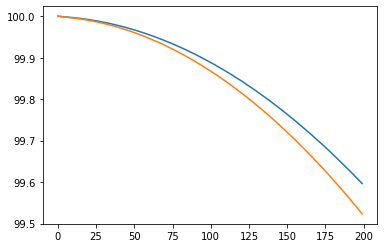

In [334]:
history = train_rnn_model(rnn_model_3, patience=5, epochs=200)
plt.plot(history.history['mape'])
plt.plot(history.history['val_mape'])
plt.show();

In [327]:
# 3. Training
from typing import overload


def train_rnn_model(model, patience=20, epochs=200):
    es = EarlyStopping(monitor = 'val_loss',
                    patience = patience,
                    verbose = 0,
                    restore_best_weights = True)
    # The fit
    history =  model.fit(X_train,
            y_train, 
            validation_split=0.1, # Auto split for validation data
                ## validation_data = (X_val, y_val), # To be created manually if needed
            batch_size = 16,
            epochs = epochs,
            callbacks = [es],
            verbose=1)
    return history


print(type(overfit_es), overfit_es)
# if overfit_es:
#     print("early stopping")
#     history = train_rnn_model(patience=overfit_es)
# else:
# print("No early stopping")
# history = train_rnn_model()

<class 'list'> [50, 66, 26, 45, 60]


In [ ]:
# 3. Training
from typing import overload


def train_rnn_model_val_set(model, patience=20, epochs=200):
    es = EarlyStopping(monitor = 'val_loss',
                    patience = patience,
                    verbose = 0,
                    restore_best_weights = True)
    # The fit
    history =  model.fit(X_train,
            y_train, 
            ## validation_split=0.1, # Auto split for validation data
            validation_data = (X_val, y_val), # To be created manually if needed
            batch_size = 16,
            epochs = epochs,
            callbacks = [es],
            verbose=1)
    return history


print(type(overfit_es), overfit_es)
# if overfit_es:
#     print("early stopping")
#     history = train_rnn_model(patience=overfit_es)
# else:
# print("No early stopping")
# history = train_rnn_model()

<class 'list'> [50, 66, 26, 45, 60]


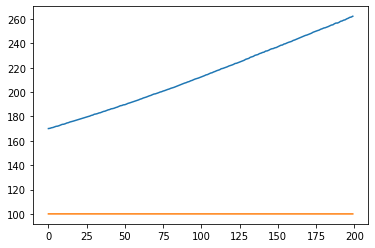

In [293]:
plt.plot(history.history['mape'])
plt.plot(history.history['val_mape'])
plt.show();

type(overfit_es), overfit_es <class 'list'> [50, 66, 26, 45, 60]
Epoch 1/50
23/23 [==============================] - 2s 33ms/step - loss: 1222676709376.0000 - mape: 99.9999 - val_loss: 1118381801472.0000 - val_mape: 99.9998
Epoch 2/50
23/23 [==============================] - 1s 24ms/step - loss: 1222671335424.0000 - mape: 99.9996 - val_loss: 1118376296448.0000 - val_mape: 99.9992
Epoch 3/50
23/23 [==============================] - 1s 24ms/step - loss: 1222665175040.0000 - mape: 99.9991 - val_loss: 1118370660352.0000 - val_mape: 99.9987
Epoch 4/50
23/23 [==============================] - 1s 24ms/step - loss: 1222660063232.0000 - mape: 99.9987 - val_loss: 1118366597120.0000 - val_mape: 99.9982
Epoch 5/50
23/23 [==============================] - 1s 26ms/step - loss: 1222658228224.0000 - mape: 99.9990 - val_loss: 1118367514624.0000 - val_mape: 99.9993
Epoch 6/50
23/23 [==============================] - 1s 27ms/step - loss: 1222655737856.0000 - mape: 99.9992 - val_loss: 1118364631040.0000 -

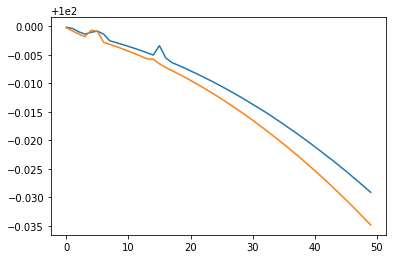

Epoch 1/150
23/23 [==============================] - 1s 25ms/step - loss: 1222256099328.0000 - mape: 99.9699 - val_loss: 1117989371904.0000 - val_mape: 99.9640
Epoch 2/150
23/23 [==============================] - 1s 25ms/step - loss: 1222241812480.0000 - mape: 99.9689 - val_loss: 1117976264704.0000 - val_mape: 99.9628
Epoch 3/150
23/23 [==============================] - 1s 24ms/step - loss: 1222227918848.0000 - mape: 99.9679 - val_loss: 1117963157504.0000 - val_mape: 99.9616
Epoch 4/150
23/23 [==============================] - 1s 24ms/step - loss: 1222213632000.0000 - mape: 99.9669 - val_loss: 1117949919232.0000 - val_mape: 99.9604
Epoch 5/150
23/23 [==============================] - 1s 25ms/step - loss: 1222199083008.0000 - mape: 99.9658 - val_loss: 1117936418816.0000 - val_mape: 99.9592
Epoch 6/150
23/23 [==============================] - 1s 24ms/step - loss: 1222184402944.0000 - mape: 99.9648 - val_loss: 1117922656256.0000 - val_mape: 99.9579
Epoch 7/150
23/23 [=====================

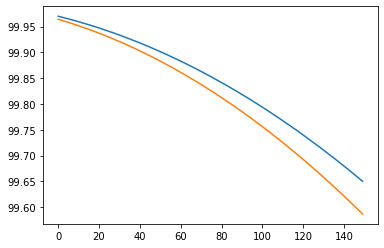

Epoch 1/200
23/23 [==============================] - 1s 25ms/step - loss: 1217718779904.0000 - mape: 99.6468 - val_loss: 1113791004672.0000 - val_mape: 99.5830
Epoch 2/200
23/23 [==============================] - 1s 24ms/step - loss: 1217671725056.0000 - mape: 99.6435 - val_loss: 1113747488768.0000 - val_mape: 99.5790
Epoch 3/200
23/23 [==============================] - 1s 24ms/step - loss: 1217624670208.0000 - mape: 99.6402 - val_loss: 1113703841792.0000 - val_mape: 99.5750
Epoch 4/200
23/23 [==============================] - 1s 25ms/step - loss: 1217577091072.0000 - mape: 99.6369 - val_loss: 1113659932672.0000 - val_mape: 99.5711
Epoch 5/200
23/23 [==============================] - 1s 25ms/step - loss: 1217530036224.0000 - mape: 99.6334 - val_loss: 1113616809984.0000 - val_mape: 99.5671
Epoch 6/200
23/23 [==============================] - 1s 25ms/step - loss: 1217482063872.0000 - mape: 99.6301 - val_loss: 1113572769792.0000 - val_mape: 99.5631
Epoch 7/200
23/23 [=====================

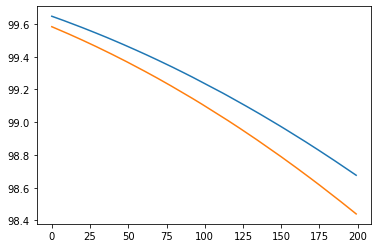

Epoch 1/300
23/23 [==============================] - 1s 25ms/step - loss: 1204049936384.0000 - mape: 98.6693 - val_loss: 1101177028608.0000 - val_mape: 98.4324
Epoch 2/300
23/23 [==============================] - 1s 25ms/step - loss: 1203960414208.0000 - mape: 98.6631 - val_loss: 1101092618240.0000 - val_mape: 98.4247
Epoch 3/300
23/23 [==============================] - 1s 24ms/step - loss: 1203869712384.0000 - mape: 98.6565 - val_loss: 1101009256448.0000 - val_mape: 98.4171
Epoch 4/300
23/23 [==============================] - 1s 24ms/step - loss: 1203779141632.0000 - mape: 98.6501 - val_loss: 1100925239296.0000 - val_mape: 98.4094
Epoch 5/300
23/23 [==============================] - 1s 25ms/step - loss: 1203689357312.0000 - mape: 98.6433 - val_loss: 1100843712512.0000 - val_mape: 98.4019
Epoch 6/300
23/23 [==============================] - 1s 24ms/step - loss: 1203598393344.0000 - mape: 98.6370 - val_loss: 1100758515712.0000 - val_mape: 98.3941
Epoch 7/300
23/23 [=====================

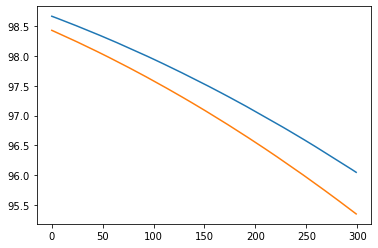

Epoch 1/400
23/23 [==============================] - 1s 25ms/step - loss: 1167666970624.0000 - mape: 96.0342 - val_loss: 1067658838016.0000 - val_mape: 95.3323
Epoch 2/400
23/23 [==============================] - 1s 24ms/step - loss: 1167515058176.0000 - mape: 96.0228 - val_loss: 1067519770624.0000 - val_mape: 95.3193
Epoch 3/400
23/23 [==============================] - 1s 24ms/step - loss: 1167362359296.0000 - mape: 96.0117 - val_loss: 1067378671616.0000 - val_mape: 95.3062
Epoch 4/400
23/23 [==============================] - 1s 23ms/step - loss: 1167210053632.0000 - mape: 96.0006 - val_loss: 1067238424576.0000 - val_mape: 95.2931
Epoch 5/400
23/23 [==============================] - 1s 23ms/step - loss: 1167056699392.0000 - mape: 95.9895 - val_loss: 1067097325568.0000 - val_mape: 95.2799
Epoch 6/400
23/23 [==============================] - 1s 24ms/step - loss: 1166902427648.0000 - mape: 95.9785 - val_loss: 1066955440128.0000 - val_mape: 95.2666
Epoch 7/400
23/23 [=====================

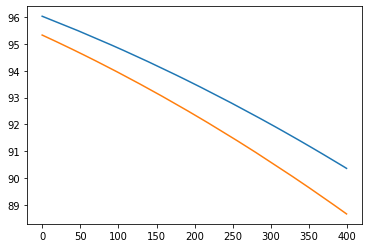

In [329]:
train_series = [50, 150, 200, 300, 400]
overfit_es =   [50, 66, 26, 45, 60 ]
print('type(overfit_es), overfit_es', type(overfit_es), overfit_es)
# if overfit_es:
#     print("early stopping")
#     history = train_rnn_model(patience=overfit_es)
# else:
# print("No early stopping")
for i in range(len(train_series)):
    history = train_rnn_model(model=rnn_model, epochs=train_series[i], patience=overfit_es[i])
    plt.plot(history.history['mape'])
    plt.plot(history.history['val_mape'])
    plt.show();

type(overfit_es), overfit_es <class 'list'> [50, 66, 26, 45, 60]
Epoch 1/50
23/23 [==============================] - 2s 50ms/step - loss: 1222676709376.0000 - mape: 99.9997 - val_loss: 1118383636480.0000 - val_mape: 99.9996
Epoch 2/50
23/23 [==============================] - 1s 37ms/step - loss: 1222674481152.0000 - mape: 99.9996 - val_loss: 1118380883968.0000 - val_mape: 99.9994
Epoch 3/50
23/23 [==============================] - 1s 37ms/step - loss: 1222671204352.0000 - mape: 99.9994 - val_loss: 1118377345024.0000 - val_mape: 99.9992
Epoch 4/50
23/23 [==============================] - 1s 37ms/step - loss: 1222668451840.0000 - mape: 99.9992 - val_loss: 1118375378944.0000 - val_mape: 99.9990
Epoch 5/50
23/23 [==============================] - 1s 37ms/step - loss: 1222666747904.0000 - mape: 99.9991 - val_loss: 1118373281792.0000 - val_mape: 99.9988
Epoch 6/50
23/23 [==============================] - 1s 39ms/step - loss: 1222664126464.0000 - mape: 99.9989 - val_loss: 1118371053568.0000 -

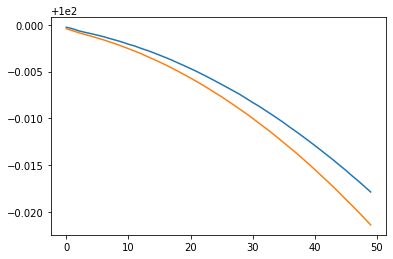

Epoch 1/150
23/23 [==============================] - 1s 38ms/step - loss: 1222419808256.0000 - mape: 99.9815 - val_loss: 1118142857216.0000 - val_mape: 99.9779
Epoch 2/150
23/23 [==============================] - 1s 37ms/step - loss: 1222411026432.0000 - mape: 99.9809 - val_loss: 1118134730752.0000 - val_mape: 99.9772
Epoch 3/150
23/23 [==============================] - 1s 37ms/step - loss: 1222402375680.0000 - mape: 99.9803 - val_loss: 1118126604288.0000 - val_mape: 99.9764
Epoch 4/150
23/23 [==============================] - 1s 37ms/step - loss: 1222393462784.0000 - mape: 99.9796 - val_loss: 1118118346752.0000 - val_mape: 99.9757
Epoch 5/150
23/23 [==============================] - 1s 37ms/step - loss: 1222384418816.0000 - mape: 99.9790 - val_loss: 1118109958144.0000 - val_mape: 99.9749
Epoch 6/150
23/23 [==============================] - 1s 37ms/step - loss: 1222375112704.0000 - mape: 99.9784 - val_loss: 1118101307392.0000 - val_mape: 99.9741
Epoch 7/150
23/23 [=====================

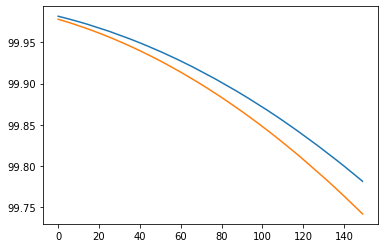

Epoch 1/200
23/23 [==============================] - 1s 40ms/step - loss: 1219582492672.0000 - mape: 99.7796 - val_loss: 1115517485056.0000 - val_mape: 99.7398
Epoch 2/200
23/23 [==============================] - 1s 39ms/step - loss: 1219553394688.0000 - mape: 99.7775 - val_loss: 1115490353152.0000 - val_mape: 99.7373
Epoch 3/200
23/23 [==============================] - 1s 38ms/step - loss: 1219523510272.0000 - mape: 99.7755 - val_loss: 1115462828032.0000 - val_mape: 99.7348
Epoch 4/200
23/23 [==============================] - 1s 38ms/step - loss: 1219493888000.0000 - mape: 99.7734 - val_loss: 1115435433984.0000 - val_mape: 99.7323
Epoch 5/200
23/23 [==============================] - 1s 37ms/step - loss: 1219464134656.0000 - mape: 99.7712 - val_loss: 1115407777792.0000 - val_mape: 99.7298
Epoch 6/200
23/23 [==============================] - 1s 37ms/step - loss: 1219434250240.0000 - mape: 99.7691 - val_loss: 1115380514816.0000 - val_mape: 99.7273
Epoch 7/200
23/23 [=====================

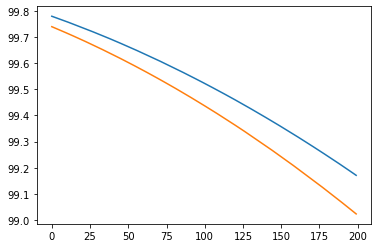

Epoch 1/300
23/23 [==============================] - 1s 37ms/step - loss: 1210998325248.0000 - mape: 99.1671 - val_loss: 1107593134080.0000 - val_mape: 99.0187
Epoch 2/300
23/23 [==============================] - 1s 37ms/step - loss: 1210941833216.0000 - mape: 99.1631 - val_loss: 1107540836352.0000 - val_mape: 99.0140
Epoch 3/300
23/23 [==============================] - 1s 36ms/step - loss: 1210884685824.0000 - mape: 99.1591 - val_loss: 1107487883264.0000 - val_mape: 99.0091
Epoch 4/300
23/23 [==============================] - 1s 39ms/step - loss: 1210827931648.0000 - mape: 99.1549 - val_loss: 1107436109824.0000 - val_mape: 99.0044
Epoch 5/300
23/23 [==============================] - 1s 44ms/step - loss: 1210771570688.0000 - mape: 99.1508 - val_loss: 1107383943168.0000 - val_mape: 98.9997
Epoch 6/300
23/23 [==============================] - 1s 40ms/step - loss: 1210714161152.0000 - mape: 99.1468 - val_loss: 1107330727936.0000 - val_mape: 98.9948
Epoch 7/300
23/23 [=====================

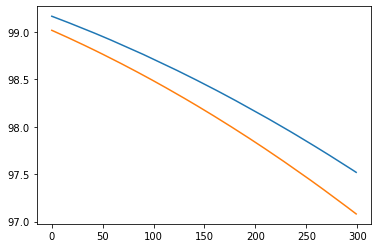

Epoch 1/400
23/23 [==============================] - 1s 39ms/step - loss: 1188002660352.0000 - mape: 97.5133 - val_loss: 1086396694528.0000 - val_mape: 97.0732
Epoch 2/400
23/23 [==============================] - 1s 38ms/step - loss: 1187905929216.0000 - mape: 97.5063 - val_loss: 1086307106816.0000 - val_mape: 97.0649
Epoch 3/400
23/23 [==============================] - 1s 38ms/step - loss: 1187809198080.0000 - mape: 97.4992 - val_loss: 1086218436608.0000 - val_mape: 97.0568
Epoch 4/400
23/23 [==============================] - 1s 38ms/step - loss: 1187713777664.0000 - mape: 97.4921 - val_loss: 1086129700864.0000 - val_mape: 97.0486
Epoch 5/400
23/23 [==============================] - 1s 38ms/step - loss: 1187615473664.0000 - mape: 97.4854 - val_loss: 1086038605824.0000 - val_mape: 97.0401
Epoch 6/400
23/23 [==============================] - 1s 38ms/step - loss: 1187518349312.0000 - mape: 97.4781 - val_loss: 1085950001152.0000 - val_mape: 97.0320
Epoch 7/400
23/23 [=====================

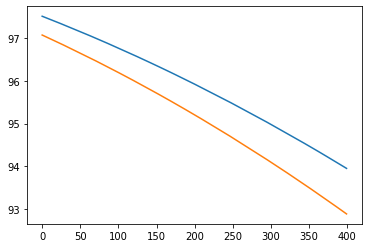

In [328]:
train_series = [50, 150, 200, 300, 400]
overfit_es =   [25, 60, 26, 45, 60 ]
print('type(overfit_es), overfit_es', type(overfit_es), overfit_es)
# if overfit_es:
#     print("early stopping")
#     history = train_rnn_model(patience=overfit_es)
# else:
# print("No early stopping")
for i in range(len(train_series)):
    history = train_rnn_model(model=rnn_model_2, epochs=train_series[i], patience=overfit_es[i])
    plt.plot(history.history['mape'])
    plt.plot(history.history['val_mape'])
    plt.show();

In [291]:
# min(history.history['mape'])

# print("adjust early stopping")
# overfit_es = [d[0]+1 for d in enumerate(history.history['mape']) if d[1] == min(history.history['mape'])][0]
# overfit_es

adjust early stopping


1

In [283]:
min(history.history['mape']), max(history.history['mape']), history.history['mape'] # blue line

(93.32080841064453,
 110.94117736816406,
 [102.72049713134766,
  103.1986312866211,
  103.71568298339844,
  103.85726928710938,
  104.09845733642578,
  104.21675109863281,
  104.36982727050781,
  104.46085357666016,
  104.77281951904297,
  104.89879608154297,
  105.12991333007812,
  105.44536590576172,
  105.27677917480469,
  105.03587341308594,
  104.72063446044922,
  104.48173522949219,
  104.32565307617188,
  104.12104797363281,
  104.05792236328125,
  104.03466033935547,
  103.83403015136719,
  103.77072143554688,
  103.67012023925781,
  103.5167236328125,
  103.51243591308594,
  103.47105407714844,
  103.0933609008789,
  103.08506774902344,
  103.013671875,
  102.88091278076172,
  102.82381439208984,
  102.55425262451172,
  102.50320434570312,
  102.48990631103516,
  102.38920593261719,
  102.35189819335938,
  102.29324340820312,
  102.23555755615234,
  102.00746154785156,
  101.97571563720703,
  101.91748809814453,
  101.83138275146484,
  101.74169921875,
  101.6371078491211,
  1

In [284]:
max(history.history['val_mape']), history.history['val_mape'] # orange line

(99.99989318847656,
 [99.99989318847656,
  99.99983215332031,
  99.99977111816406,
  99.99971008300781,
  99.99964904785156,
  99.99957275390625,
  99.99952697753906,
  99.9994888305664,
  99.99944305419922,
  99.9994125366211,
  99.99937438964844,
  99.99934387207031,
  99.99931335449219,
  99.99928283691406,
  99.99925994873047,
  99.99922943115234,
  99.99920654296875,
  99.99918365478516,
  99.99916076660156,
  99.99913024902344,
  99.99910736083984,
  99.99908447265625,
  99.99906158447266,
  99.99903869628906,
  99.99900817871094,
  99.99898529052734,
  99.99896240234375,
  99.99893951416016,
  99.99891662597656,
  99.99888610839844,
  99.99885559082031,
  99.99883270263672,
  99.99881744384766,
  99.99879455566406,
  99.99876403808594,
  99.99873352050781,
  99.99870300292969,
  99.9986801147461,
  99.9986572265625,
  99.99864196777344,
  99.99861907958984,
  99.99859619140625,
  99.9985580444336,
  99.99854278564453,
  99.99851989746094,
  99.99848937988281,
  99.99846649169922

### Evaluate model

In [285]:
# 4. Evaluating
# The prediction (one per sequence/city)
y_pred = rnn_model.predict(X_test) 

In [286]:
y_pred.shape

(16, 1)

## Time Series Forecasting

In [287]:
# Check your code below
assert y_pred.shape == (n_seq_test, n_pred)

## Next steps:
- Get NB dataset (cleaned) from Alberto & Sumedha
- 1/ Indicator in precentage %
- 2/ Indicator as categorical labels
- Run same RNN model in parallel with Kim & Thomas
- Identify best dataset
- Parameters to fit:
    - increase **nb of sequences**
    - train series modulation (ex: [50, 150, 200, 300, 400 nb of days = n_obs]) < take time to compute
    - **learning_rate** in Optimizer(parameters)
    - model layers architecture (**simple** -> complex) (less data -> more data) (print(loss) function check lecture)
        > LSTM
        > Dense
       (> LSTM
        > LSTM
        > Dense)
     >> **try to overfit** the model with the loss (train over val) or (early_stopping)
     >> **(X_val, y_val)**